# _Long/Short Strategy Portfolio Analyses_

The following notebook will introduce you a performance analyses of our L/SH strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the EONIA +4% (per year) and fees are applied annually.

How to spread 4% per year into monthly returns ? We assume that +4% per year = to 0.327% per month ($x^{12}= 1.04 \iff x= 0.00327$). Then, we add this constant float to EONIA monthly rates. We will call this new series EONIA4.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

import warnings
warnings.filterwarnings("ignore")

In [14]:
data= pd.read_csv("../data/long_short_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['eonia_4'] = (data['eonia'].str.replace(',','.').astype(float)/100)+ 0.00327
data['eonia'] = (data['eonia'].str.replace(',','.').astype(float)/100)
data['effectif'] = data['effectif']/100
data['pred'] = data['pred']/100

### A). Quick statistics

In [5]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['EONIA +4%', str(round(data['eonia_4'].mean()*100,2))+'%', str(round(data['eonia_4'].std()*100,2))+'%',
             str(round(kurtosis(data['eonia_4']),2)),  str(round(skew(data['eonia_4']),2))], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2)),  str(round(skew(data['effectif']),2))
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['eonia_4'].mean()*100),3)) 
print('The Excess Return of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark (EONIA4)')

+-----------+-------------+-------+----------+----------+
|  Series   | Mean Return |  Std  | Kurtosis | Skewness |
+===========+=============+=======+==========+==========+
| EONIA +4% | 0.29%       | 0.39% | 1.240    | 1.330    |
+-----------+-------------+-------+----------+----------+
| Portfolio | 0.26%       | 4.42% | 1.810    | -0.300   |
+-----------+-------------+-------+----------+----------+
The Excess Return of our Portfolio on average is: -0.034% compared to our benchmark (EONIA4)



- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile. 
- Correlation between our series: -9.4%


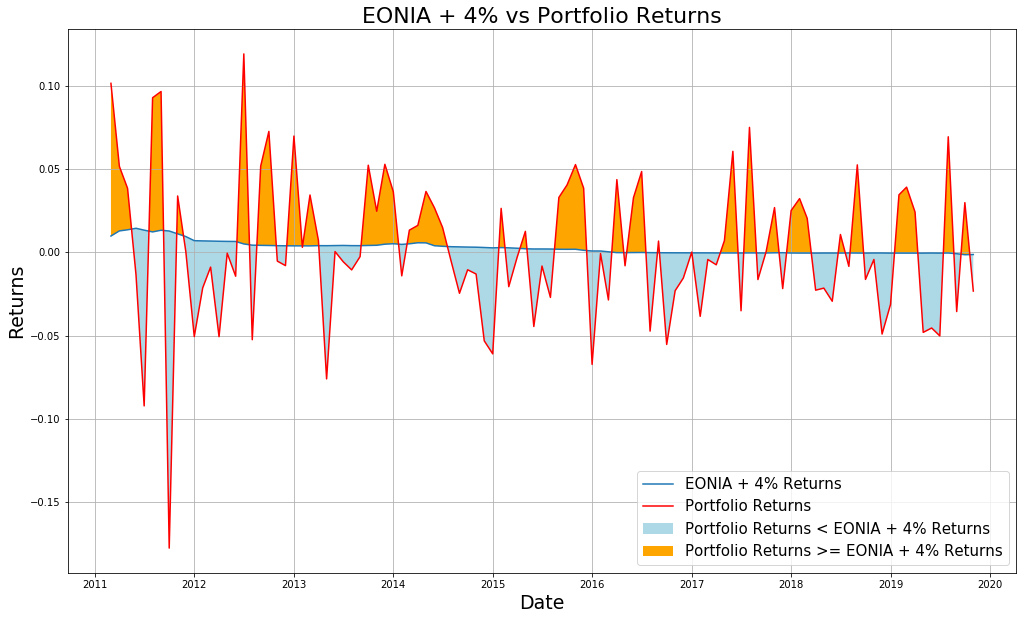

In [6]:
plt.figure(figsize=(17,10))
plt.plot(data.date, data.eonia_4, label='EONIA + 4% Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above EONIA + 4%, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < EONIA + 4% Returns")
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] <= data["effectif"]
                , facecolor= "orange"
                , interpolate= True
                , label= "Portfolio Returns >= EONIA + 4% Returns")


plt.title('EONIA + 4% vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

### B). Notes about normality distribution, random walk and extreme returns

In [8]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Fréquence", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

                                   Portfolio                                    


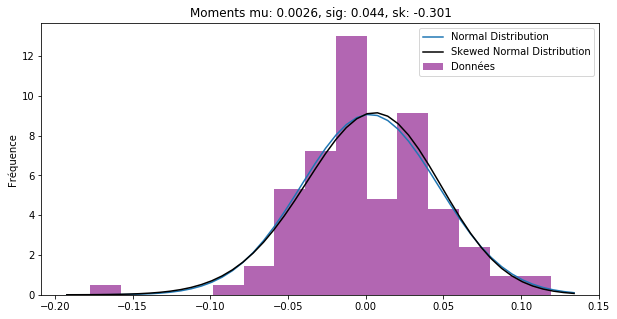


 

                                     EONIA4                                     


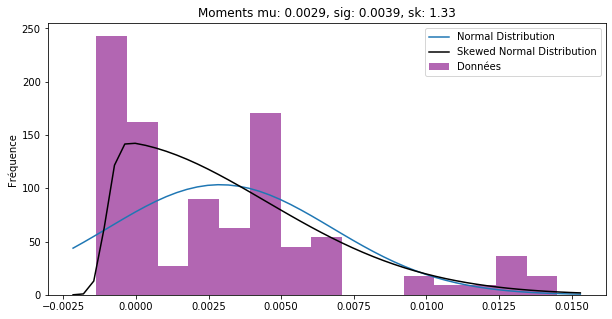

In [9]:
# Our portfolio returns
print("Portfolio".center(80))
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["effectif"].values], bins= 15)

# EONIA distribution
print("\n","\n")
print("EONIA4".center(80))
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["eonia_4"].values], bins= 15)

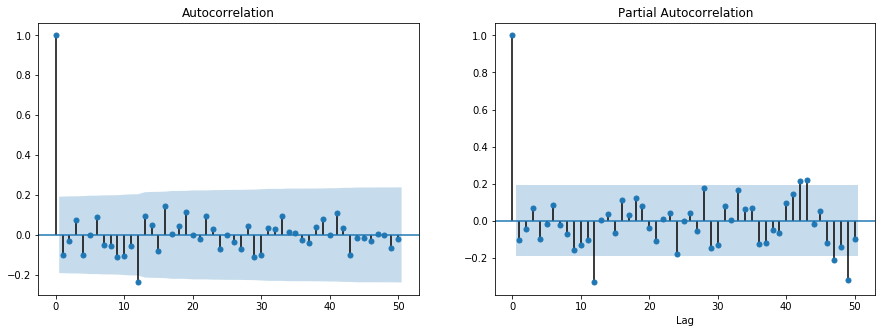

In [10]:
# Autocorrelation for all periods (with confidence intervals)

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data["effectif"], lags= 50 , ax=ax[0])
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 50,ax=ax[1])
plt.xlabel("Lag")
plt.show()

_Our Portfolio on average under-performs the benchmark with a higher standard deviation (fees not included). The EONIA itself has an average return close to 0%, the bump up is pushed thanks to the +4% annually and we find average return found if we transform the 4% monthly. The std is shows a real volatility of our Portfolio since is a real active and risky strategy. Shorting a stock is more difficult then staying long on an asset._

_As we said in the Long Analyses Kurtosis will be compared to the normal distribution. Here both of our series have a positive kurtosis between 1-2, meaning that they will be leptokurtic. In general, leptokurtic distributions have heavier tails or a higher probability of extreme outliers value compared the the normal distribution. Anyway if the benchmark has a lower kurtosis than our Portfolio, meaning that the extreme events will be less frequent._

_Investors note skewness when judging a return distribution because it, like kurtosis, considers the extremes of the data set rather than focusing solely on the average. Here we find a positive skew for the EONIA4, something expected since the negative values were really shown only recently and we have been monthly on the positive side. In the other hand, our Portfolio present negative returns but still symmetrical since is higher than -0.5._

_Both of our series are off, so not even considered as normal even if our datasets gets larger. This can be easily spotted even graphically._ 

_Last but not least the ACF and the PACF shows some correlation with the 12th month lag, being purely by chance. Having also some correlation in the end of the 50 month period we can conclude that we don't have a random walk. (significance at 5%)._ 
   
_All the results are better shown above._

### C). Rolling metrics

In [11]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["eonia_4"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["eonia_4"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["eonia_4"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

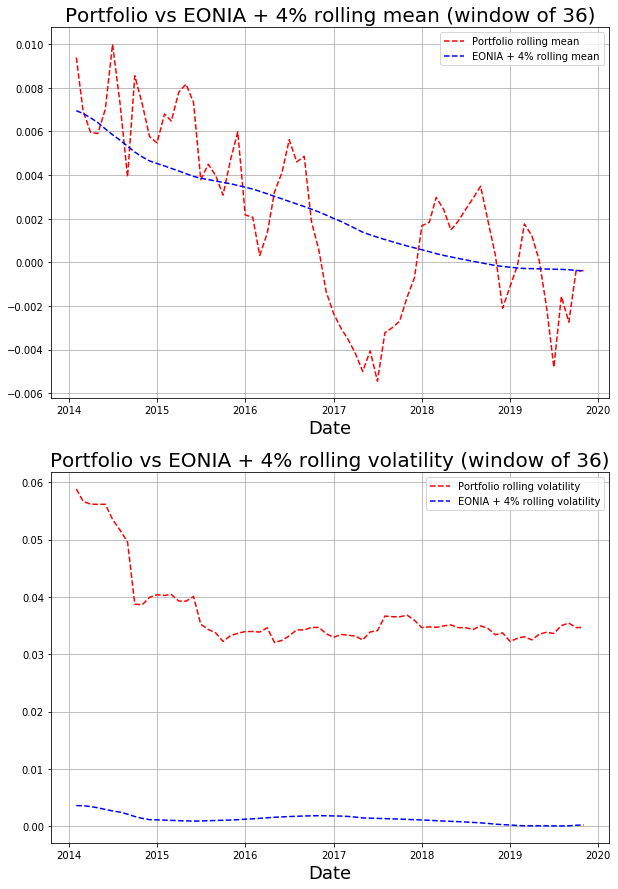

In [12]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (10, 15))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs EONIA + 4% rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 20)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 20)

for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 18)
    ax[i].grid()
    ax[i].legend()

plt.show()

_Taking a rolling window of 36 points has the following consequence on our returns and volatility of taking into consideration every economical/financial impact from the last 3 years (starting from 2011). As we all know, we are taking into account, Black Monday, European Debt Crisis, Trump election, Brexit etc._

_We can clearly see the stability versus the big volatility of our Portfolio. Unfortunately this is due to our Long/Short strategy. As mentioned before, it is a real challenge to try and short equities in a Bull Market run. We see a severe downturn in late 2017 but the effects could be earlier. Unfortunately we don't know the equities that are inside the Portfolio during the whole period since we re-balance every month and compute a moving metric._

_The volatility of EONIA4 will always be stable since the real EONIA is always close to zero and around that since 08'. The volatility of our Portfolio starts to stabilize around 2014-2015 when the effects of the Black Monday and EDC starts to disappear, however we remain above EONIA4._

### D). Portfolio evaluation

#### 1).

In [15]:
# Applying fees and performance expenses

df = data.copy()

# We transform the annual (1% management fees) to monthly instalments.
fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe of 10, 11 and 12 months
a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# The length of the two should match
len(a) == len(b)

True

In [16]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        # Transforming the excess return fee into monthly instalments.
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(10)) - 1
        
        # If we beat our benchmark, a 20% fee on the excess return is applied monthly.
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(12)) - 1

        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(11)) - 1
        
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees) 

# Adding the final transformed returns after taking out the management fees and the excess return fee. 
df['final_ppt'] = np.concatenate(portfolio_final, axis=0)
data2= df.copy()

In [17]:
t = Texttable()
t.add_rows([['Series', 'Total Return' ,'Annualized Total Return' ], 
            ['EONIA4', str(round(list((1+data['eonia_4']).cumprod())[-1]-1,3)*100)+'%',
            str(round(((1+round(list((1+data['eonia_4']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%',
             str(round(((1+round(list((1+data['effectif']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,2)*100)+'%',
             str(round(((1+round(list((1+data2['final_ppt']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ]
           ])
print(t.draw())

+--------------------------+--------------+-------------------------+
|          Series          | Total Return | Annualized Total Return |
+==========================+==============+=========================+
| EONIA4                   | 35.4%        | 3.49%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (without fees) | 18.0%        | 1.91%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (with fees)    | 6.0%         | 0.67%                   |
+--------------------------+--------------+-------------------------+


In [18]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Benchmark', 'Alpha' , 'Beta'], 
            ['EONIA4', str(round(alpha*100,3))+' %',str(round(beta,2))]])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["eonia_4"].values, data["effectif"].values)

print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["eonia_4"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+-----------+---------+-------+
| Benchmark |  Alpha  | Beta  |
+===========+=========+=======+
| EONIA4    | 0.014 % | 0.830 |
+-----------+---------+-------+

The results are shown for the entire period (with fees)
+-----------+----------+-------+
| Benchmark |  Alpha   | Beta  |
+===========+==========+=======+
| EONIA4    | -0.092 % | 0.830 |
+-----------+----------+-------+


The fees that were expected to be applied were the following ones:
- Management fees of 1% applied annually
- Performance fees of 20% if the benchmark was beaten annually.

_Starting with management fees we transformed annually fees to monthly installments using $x^{12} = 1.01$ and applied this fee monthly. We tried to do the same with the performance fees but the task was a little bit trickier. We needed to calculate the cumulative product of our series per year meaning that the end of the year will always be December. The following problem appeared, we found that the the first year was only 10 months and the last year was only 11 months, so we thought of using the index of the 12th month to slice our dataset in periods. For each period we calculate the cumprod(annual return) followed by a comparison with the EONIA4 annual return. If our Portfolio performance was higher than the EONIA4, we deduct 20% of the excess return. So simplify our approach as we said earlier, this fee was applied monthly by transforming it in monthly and recreating the initial returns._

_The results were a little bit deceiving since even without deducting the fees we were we weren't even close to beat our benchmark. In annualized total return the EONIA4 was 3.49% lower than the SPX 10.36% but still higher than our Portfolio with and without fees. In total return we managed 18% without fees and by adding the fees we drop as low as 6%. Adding transaction costs would be even worst. The performance will be better shown in the chart below._ 

_Our Alpha was totally destroyed after adding the fees. This was due to our low Alpha initially. Concerning our Beta,______________________________________________ ._

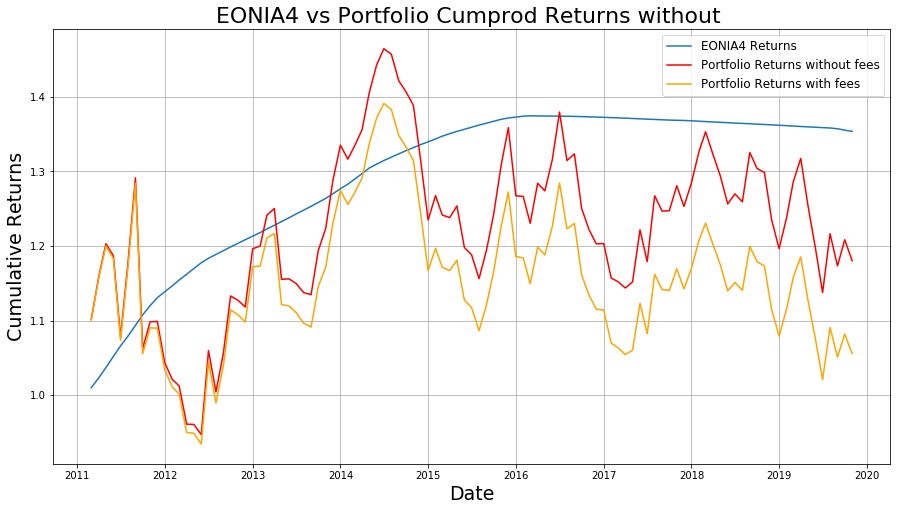

In [15]:
plt.figure(figsize=(15,8))
plt.plot(data.date,(1+data['eonia_4']).cumprod(),label='EONIA4 Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns without fees')
plt.plot(data2.date,(1+data2['final_ppt']).cumprod(), c='orange', label='Portfolio Returns with fees')
plt.title('EONIA4 vs Portfolio Cumprod Returns without ', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

#### 2).

In [19]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [20]:
roll_alpha = []
roll_beta = []

for be, al in zip((windows(data["eonia_4"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["eonia_4"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


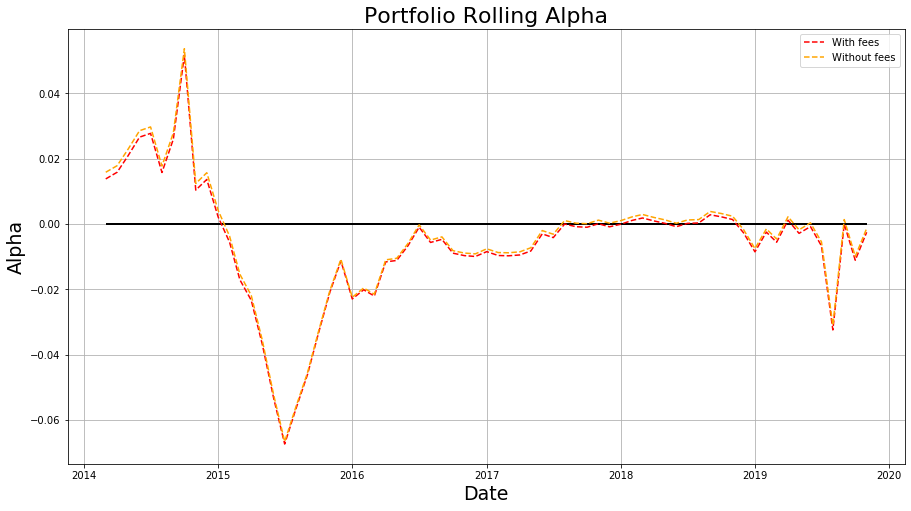

In [21]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36 points.


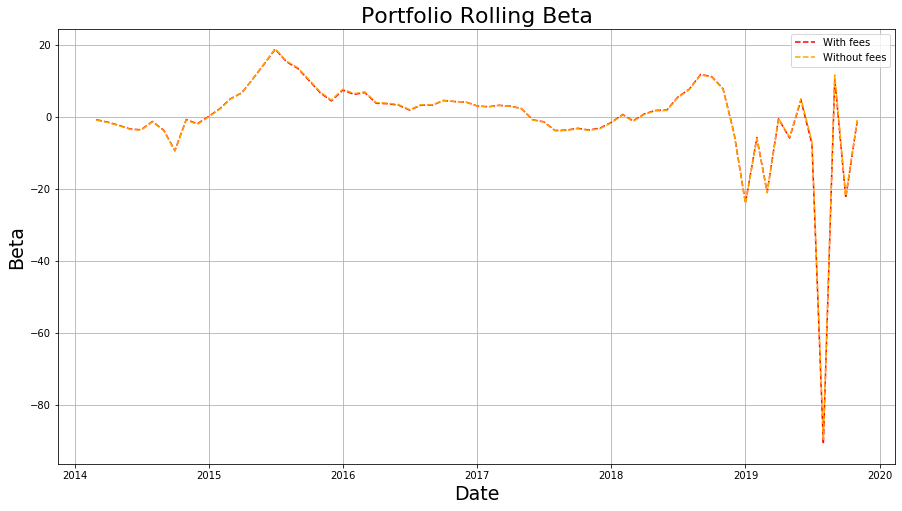

In [22]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

# plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36 points.')
plt.show()

_Our Rolling Alpha remains stable across the two series but the chart shows what we were expecting in late 2015, the sharp drop gave the effects in the late 2017 in the rolling mean chart. Overall we had a good Alpha at the beginning but we couldn't produce a stable positive Alpha during the next years. As we mentioned before, a Short/Long strategy is not the easiest one, especially when we are in a bull run. Finding companies that will under-perform is more difficult than finding companies that will outperform the market, this was better shown with our Long Only Strategy._

_Beta_